# Assignment 4

## Instructions
<ul>
    <li> Ensure that this assignment is your own work. PLagiarism will not be tolerated </li>
    <li> Ensure that all cells of this notebook run without error when run in order </li>
    <li> Follow the late day policy. Submit assignments on time </li>
    <li> Provide clear explanation for the algorithms you implement </li>
</ul>
Date released: 26/10/2020 

Due date: 01/11/2020 

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

---
## 4.1
### Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [3]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from __future__ import print_function, division
import os
import glob
import sys, argparse
import pprint
import cv2
from scipy import optimize as opt

image_points = []
fig = plt.figure(figsize=(20,30))

img=mpimg.imread('Images/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    # print(ix, iy)
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

In [ ]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [5]:
#We'll rename image_points to x to match textbook convention
x = image_points
# X represents the 3D world points
X = []
#Add your points here
#Add them as 3D points only
X.append([0,0,0])
X.append([0,0,4])
X.append([0,4,0])
X.append([4,0,0])
X.append([4,0,4])
X.append([0,4,4])
X.append([4,4,4])

X = np.array(X)
print(x)
print(X.shape)
print("ok")

[[337.79692379 725.74683331]
 [347.02074559 493.30652393]
 [129.33855109 581.85521322]
 [516.73906673 572.63139142]
 [566.54770445 338.34631768]
 [ 94.28802825 338.34631768]
 [321.19404455 216.59186991]]
(7, 3)
ok


In [6]:
#Helper functions
#appends a ones column to input
def hom_coords(x,X):
    n = x.shape[0]
    size = (n,1)
    ones = np.ones(size)
    x = np.concatenate((x,ones),axis = 1)
    X = np.concatenate((X,ones),axis = 1)
    return x, X

print(X.shape)
x,X = hom_coords(x,X)
print(X.shape)

(7, 3)
(7, 4)


#### Explanation

Edit this cell and explain the DLT algorithm:

DLT maps any point in the world frame X to image point x using the camera matrix P - 

$$
x = PX
$$

Given 7 correspondences from world to image frame, we get 2 equations from each point -
$$
\alpha_i^Tp = \begin{bmatrix} -X_i & -Y_i &-Z_i &  -1 & 0  & 0 & 0 & 0 & x_i X_i & x_i Y_i & x_i Z_i & x_i \\ 
0 & 0 & 0 & 0 & -X_i & -Y_i &-Z_i &  -1 &  y_i X_i & y_i Y_i & y_i Z_i & y_i
  \end{bmatrix}
  \begin{bmatrix}
  p_{11}
  \\ p_{12}
  \\ p_{13} 
  \\ p_{14}
  \\ p_{21}
  \\ p_{22}
  \\ p_{23}
  \\ p_{24}
  \\ p_{31}
  \\ p_{32}
  \\ p_{33}
  \\ p_{34}
  \end{bmatrix}
$$
Take the matrix, we get M - 
$$
M = \begin{bmatrix} 
\alpha_1^Tp
\\ \alpha_2^Tp
\\ \alpha_3^Tp
\\ \alpha_4^Tp
\\ \alpha_5^Tp
\\ \alpha_6^Tp
\\ \alpha_7^Tp
 \end{bmatrix}
$$
Take SVD of M, 
$$
M = U \Sigma V^*
$$
Compute $\Omega$ as - 
$$
\Omega = p^T M^T M p
$$
Choose $p=v_{12}$ the singular vector belonging to the smallest singular value $s_{12}$ that minmizes $\Omega$ 

F

In [7]:
#DLT function takes as input 
#the image points and world points
#return a 3x4 matrix
def DLT(x,X):
    """
    your code here
    """
    matrix = []
    for i in range(len(X)):
        # w1 = X[i][0]
        # w2 = X[i][1]
        # w3 = X[i][2]
        # i1 = x[i][0]
        # i2 = x[i][1]
        #row1 = [-w1,-w2,-w3,-1,0,0,0,0,i1*w1,i1*w2,i1*w3,i1]
        #row2 = [0,0,0,0,-w1,-w2,-w3,-1,i2*w1,i2*w2,i2*w3,i2]

        row1 = [-X[i][0],-X[i][1],-X[i][2],-1,0,0,0,0,x[i][0]*X[i][0],x[i][0]*X[i][1],x[i][0]*X[i][2],x[i][0]]
        row2 = [0,0,0,0,-X[i][0],-X[i][1],-X[i][2],-1,x[i][1]*X[i][0],x[i][1]*X[i][1],x[i][1]*X[i][2],x[i][1]]

        matrix.append(row1)
        matrix.append(row2)

	# print(matrix)
    u, s, vh = np.linalg.svd(matrix, full_matrices=False)
	# print(vh)
    vh = vh.transpose()
    P_vec = []
    for i in range(12):
        P_vec.append(vh[i][11])

	# print(P_vec)
    P_mat = []
    P_mat.append(P_vec[0:4])
    P_mat.append(P_vec[4:8])
    P_mat.append(P_vec[8:12])
    P = P_mat
    return np.array(P)

P = DLT(x,X)
print("done, P = ")
print(P)
#print(P.shape)
#print([P[0][0], P[0][1], P[0][2]])
return P

done, P = 
[[ 7.49119250e-02 -6.05650183e-02 -1.79765714e-02  4.16777459e-01]
 [-2.56978623e-02 -2.86290368e-02 -1.02309932e-01  8.97075591e-01]
 [ 3.74765290e-05  2.76331148e-05 -6.15662450e-05  1.23588711e-03]]


## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [8]:
#Get reprojected points
def get_points(P,X):
    points = P@X.T
    points = points / points[2]
    points = points.T[:,0:2]
    return points

#Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    """
    find the MSE between reprojected points
    and x
    """
    #to err is to human
    re_proj = get_points(P, X)    
    err = np.mean(np.square(re_proj - x[:,:-1]))   #squaring and taking mean
    return err

print("err = ",end="")
print(get_err(x,X,P))

err = 0.49536253675304265


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [9]:
def ret_RKT(P):
    """
    """
    H_inf = np.array([
            [P[0][0], P[0][1], P[0][2]],
            [P[1][0], P[1][1], P[1][2]],
            [P[2][0], P[2][1], P[2][2]]
            ])
    h = np.array([P[0][3], P[1][3], P[2][3]])
    H_inf_inv = np.linalg.inv(H_inf)
    T = np.dot(-H_inf_inv,h)
    R,K_inv = np.linalg.qr(H_inf_inv, mode='reduced')    
    K = np.linalg.inv(K_inv)


    for i in range(len(K)):
        for j in range(len(K[i])):
            K[i][j] = K[i][j]/K[2][2]
    return R, K , T 
    
re_proj = get_points(P, X)
R,K,T = ret_RKT(P)
#code to plot these on the image
print("K = ",end="")
print(K)


K = [[ 1.21251396e+03  8.56998807e+00  3.76033512e+02]
 [-0.00000000e+00 -1.19304285e+03  7.62721506e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Reproject the world points with P matrix you have obtained via DLT:

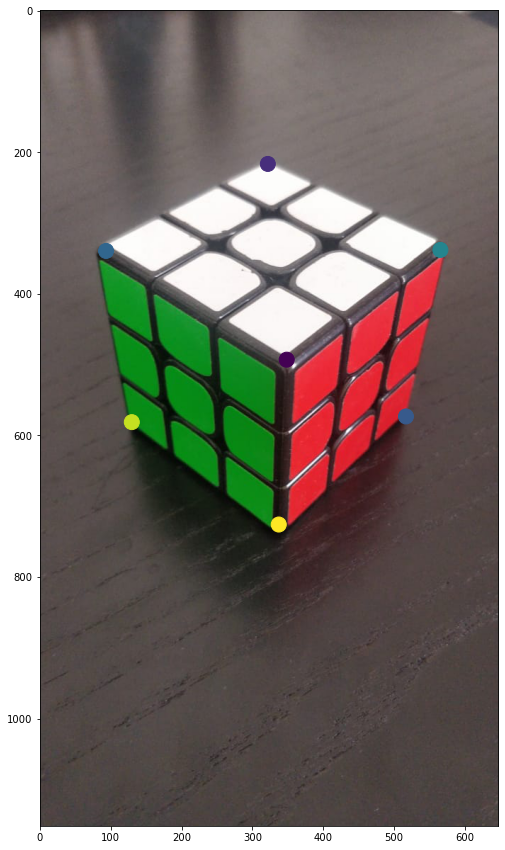

In [10]:

fig = plt.figure(figsize=(10,15))       

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)    #plotting the image

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(re_proj[:,0], re_proj[:,1], c=colors, s=area) #scattering points above iamge. 
plt.show()

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in images/zhangs folder for this task. Familiarize yourself with the different parameters for this method.

In [15]:
import cv2
print("AAAAAA")


WIDTH = 6
HEIGHT = 8
zero = np.zeros( ( WIDTH * HEIGHT ,3), np.float32)
ind = 0

for i in range(WIDTH):
    for j in range(HEIGHT):
        zero[ind][0] = j
        zero[ind][1] = i
        ind = ind + 1

image_points = []  # points on image
object_points = []  # points in the real world

DATA_DIR = "./Images/Zhangs/IMG_54"

for i  in range(56, 71):
    img = cv2.imread(DATA_DIR + str(i) + ".JPG") 
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #converting the iamge to gray scale
    rt, corners = cv2.findChessboardCorners(gray, (HEIGHT,WIDTH),None) #finding corner of chessboard
    print(i)
    print(corners.shape)
    if rt == True:  # if found        
        object_points.append(zero) #get object points
        corners = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)) #get image points
        image_points.append(corners)

_, K,  __, ___, ____ = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1],None,None) #get k matrix
print("K : ",end="")
print(K)



AAAAAA
56
(48, 1, 2)
57
(48, 1, 2)
58
(48, 1, 2)
59
(48, 1, 2)
60
(48, 1, 2)
61
(48, 1, 2)
62
(48, 1, 2)
63
(48, 1, 2)
64
(48, 1, 2)
65
(48, 1, 2)
66
(48, 1, 2)
67
(48, 1, 2)
68
(48, 1, 2)
69
(48, 1, 2)
70
(48, 1, 2)
K : [[1.36415095e+04 0.00000000e+00 3.31635924e+03]
 [0.00000000e+00 1.36632518e+04 1.50037425e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


---
## 4.2
### Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. The fundamental matrix that encodes their relative geometry as well as a subset of corresponding points have been provided to you. The images are in q2 folder.

Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image.

In [262]:
import re
data_file = "q2/data.txt"
with open(data_file, 'r') as f:
    A = f.readlines()

img_1 = []
img_2 = []
cnt = -1
for i in A:
    string = i.strip()
    if string != "":
        if string[0] == "#":
            cnt = cnt + 1
            continue
        if cnt is 0:
            num1 = int(re.search(r'\d+', string.split()[0]).group())
            num2 = int(re.search(r'\d+', string.split()[1]).group())
            img_1.append([num1,num2])
        elif cnt is 1:
            num1 = int(re.search(r'\d+', string.split()[0]).group())
            num2 = int(re.search(r'\d+', string.split()[1]).group())
            img_2.append([num1,num2])            

print("LLL")
print(img_1)
print(img_2)
F_mat = np.array([[-1.29750186e-06,  8.07894025e-07,  1.84071967e-03],
[3.54098411e-06,  1.05620725e-06, -8.90168709e-03],
[-3.29878312e-03,  5.14822628e-03,  1.00000000e+00]])
print(F_mat)
f.close()


LLL
[[381, 402], [452, 497], [671, 538], [501, 254], [506, 381], [474, 440], [471, 537], [498, 364], [706, 319], [635, 367]]
[[390, 346], [439, 412], [651, 417], [477, 194], [482, 300], [456, 359], [454, 444], [475, 287], [686, 185], [606, 253]]
[[-0.0000013   0.00000081  0.00184072]
 [ 0.00000354  0.00000106 -0.00890169]
 [-0.00329878  0.00514823  1.        ]]


Provide a clear explanation on your approach for both this task and the next:

### Explaination

Each row in lines1 corresponds to the equation of the epipolar line of the points in pt1 as a,b,c. The equation of a line is given by $ax^2 + b x + c$. For each point (x,y,z) in epiline, we draw a line from $(0,-\frac{y}{x})$ to $(c,-\frac{z + x \times c}{y})$ on the image, and we plot a circle on the image at the point. We do the same for lines2.

done
(10, 3)


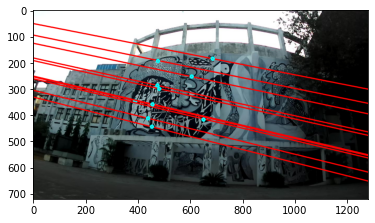

In [263]:
import cv2 as cv
#Write code to plot epipolar lines on the images
img_1 = np.array(img_1)
img_2 = np.array(img_2)
F_mat = np.array(F_MAT)
print("done")

pts1 = np.array(img_1)
pts2 = np.array(img_2)
F = np.array(F_mat)
img1 = plt.imread("q2/img1.jpg")
img2 = plt.imread("q2/img2.jpg")


pts1_final = np.append(pts1, np.ones((10,1)), axis=1) # Homogenous conversion
print(pts1_final.shape)

lines1 = np.dot(F, pts1_final.transpose())

pts2_final = np.append(pts2, np.ones((10,1)), axis=1)  # Homogenous conversion

lines2 = np.dot(pts2_final, F)

def drawlines(img1,lines, pts):
    r,c,_ = img1.shape
    for r, pt1 in zip(lines, pts):
        color1=(255,0,0)
        color2=(0,255,255)
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color1 ,4)
        img1 = cv.circle(img1, tuple(pt1), 5, color2, 5)
    return img1

img3 = drawlines(img2, lines1.transpose(), pts2)
plt.imshow(img3)
plt.show()


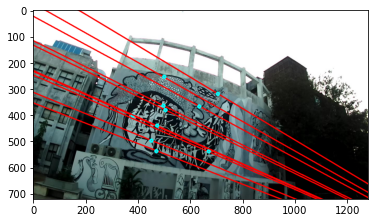

In [242]:
img4 = drawlines(img1, lines2, pts1)
plt.imshow(img4)
plt.show()

#### Task 2
Report the location of the epipoles.

### Explaination

We know that the epipoles of second image will satisfy $F^{T}e_1 = 0$ and for the first image will satisfy $Fe_2=  0$.We use linear algebra solver to get the epipoles.
We could also have taken the SVD of the fundamental matrix using the 8 point algorithm - 
$$
F = U\Sigma V^{*}
$$
Over here, $V$ will give our final matrix in homogenous coordinates, we divide it by last term.

In [264]:
print("----------------------------------------------------------------")
print("USING SOLVER : ")

a = F_mat[0:2,0:2]
b = F_mat[0:2,2]
print("Epipole of first image:",np.linalg.solve(a,-b))
a = F_mat.transpose()[0:2,0:2]
b = F_mat.transpose()[0:2,2]
print("Epipole of second image:",np.linalg.solve(a,-b))
U, Sigma, V = np.linalg.svd(F.transpose(), full_matrices=False)
print("----------------------------------------------------------------")
print("USING SVD: ")
U, Sigma, V = np.linalg.svd(F, full_matrices=False)

for i in range(len(V[2])):
    V[2][i] = V[2][i]/V[2][2]
    
print("Epipole of first image:", [V[2,:][0],V[2,:][1]])
for i in range(len(V[2])):
    aa = 3
    V[2][i] = V[2][i]/V[2][2]
    
print("Epipole of second image:",  [V[2,:][0],V[2,:][1]])
print("----------------------------------------------------------------")

----------------------------------------------------------------
USING SOLVER : 
Epipole of first image: [2159.16628178 1189.26810563]
Epipole of second image: [-5131.90964076  -948.85463472]
----------------------------------------------------------------
USING SVD: 
Epipole of first image: [2159.166283064529, 1189.268100283768]
Epipole of second image: [2159.166283064529, 1189.268100283768]
----------------------------------------------------------------
